## Задание 1. A/B–тестирование<h2>
**УСЛОВИЕ**

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

- На какие метрики Вы смотрите в ходе анализа и почему?
- Имеются ли различия в показателях и с чем они могут быть связаны?
- Являются ли эти различия статистически значимыми?
- Стоит ли запускать новую механику на всех пользователей?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import io
import urllib
import requests
import json
from urllib.parse import urlencode
import scipy.stats as stats
import pingouin as pg
import warnings
sns.set_style('whitegrid')

Считываем файлы с публичной ссылки на ЯДиск и записваем их в переменные, соответствующие названиям csv файлов

In [2]:
def read_df_API(key, delimiter):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key = key  # Сюда вписываете вашу ссылку

    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']

    # Загружаем файл и сохраняем его
    download_response = requests.get(download_url)
    file_content = download_response.content
    string_data = file_content.decode('utf-8')
    data_io = io.StringIO(string_data)
    df = pd.read_csv(data_io, sep = delimiter)
    return df


In [3]:
key = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
delimiter = ';'
group = read_df_API(key, delimiter)
group

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74479,5692459,B
74480,5692572,B
74481,5692865,B
74482,5693667,B


In [4]:
key = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'  
delimiter = ','
groups_add = read_df_API(key, delimiter)
groups_add.head()


,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [5]:
key = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'  
active_studs = read_df_API(key, delimiter)
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [6]:
key = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'  
delimiter = ';'
checks = read_df_API(key, delimiter)
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


Смотрим на данные: у нас 4 датасета. 
- **group** - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа).
- **groups_add** - дополнительный файл с пользователями, который прислали спустя 2 дня после передачи данных.
- **active_studs** - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
- **checks** - файл с информацией об оплатах пользователей в дни проведения эксперимента.

План действий:
1. Объединяем 2 датасета с информацией о принадлежности методом pd.concat()(*добавление строк в датафрейм*)
2. Объединяем получившийся датасет с датасетом active_studs методом merge()(*добавление стролбцов в датафрейм по ключевому полю*). Используя аргумент how = 'left', отсечем id, которые не появлялись в день эксперимента.
3.  Объединяем получившийся датасет с датасетом checks методом merge(). Получим финальный датафрейм с информацией об оплате.


Смотрим на данные, проверяем типы переменных, пропущенные значения: необходима ли предобработка данных.

In [7]:
group.dtypes

id      int64
grp    object
dtype: object

In [8]:
group.isna().sum()

id     0
grp    0
dtype: int64

In [9]:
groups_add.dtypes

id      int64
grp    object
dtype: object

In [10]:
groups_add.isna().sum()

id     0
grp    0
dtype: int64

In [11]:
groups_add.shape

(92, 2)

In [12]:
group.shape

(74484, 2)

In [13]:
group_fin = pd.concat([group, groups_add]) #Объединяем 2 датафрейма

In [14]:
group_fin.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [15]:
group_fin.grp.value_counts()

grp
B    59883
A    14693
Name: count, dtype: int64

<Axes: xlabel='grp', ylabel='count'>

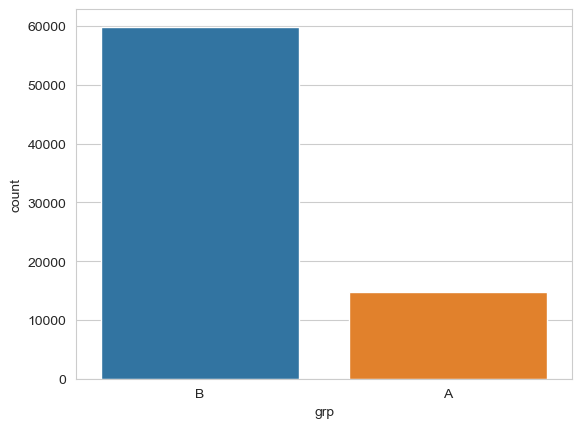

In [16]:
sns.countplot(x='grp', data = group_fin)

Группы распределены *неравномерно*

In [17]:
# Проверка уникальности значений столбца
def uniqualy(df1):
    if len(df1) == df1.nunique():
        print('Все значения уникальны')
    else:
        print('Не все значения уникальны')

In [18]:
uniqualy(group_fin.id)

Все значения уникальны


In [19]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [20]:
active_studs.dtypes

student_id    int64
dtype: object

In [21]:
active_studs.count()

student_id    8341
dtype: int64

In [22]:
active_studs.isna().sum()

student_id    0
dtype: int64

Объединяем с датафреймом с информацией о принадлежности к группе. Не забываем проверить *Nan*, все ли id нашли свои данные о том, в какой они группе.

In [23]:
active_studs_group = active_studs.merge(group_fin,  left_on='student_id', right_on='id', how = 'left')

In [24]:
active_studs_group

,student_id,id,grp
0,581585,581585,A
1,5723133,5723133,A
2,3276743,3276743,B
3,4238589,4238589,A
4,4475369,4475369,B
...,...,...,...
8336,1794344,1794344,B
8337,296883,296883,B
8338,3598448,3598448,B
8339,3610547,3610547,B


In [25]:
active_studs_group = active_studs_group.drop(['id'], axis = 1)

In [26]:
active_studs_group.isna().sum()

student_id    0
grp           0
dtype: int64

In [27]:
checks

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


In [28]:
fin_df = active_studs_group.merge(checks, on = 'student_id', how = 'outer')
fin_df # Получаем финальный датафрейм, Nan в колонке rev меняем на нули: пользователь был, но не оплатил.

,student_id,grp,rev
0,581585,A,NaN
1,5723133,A,NaN
2,3276743,B,NaN
3,4238589,A,NaN
4,4475369,B,NaN
...,...,...,...
8485,5291900,NaN,199.0
8486,5331842,NaN,290.0
8487,5486319,NaN,199.0
8488,5562806,NaN,398.0


In [29]:
fin_df.isna().sum()

student_id       0
grp            149
rev           7949
dtype: int64

In [30]:
fin_df.fillna(0, inplace = True)

In [31]:
fin_df

,student_id,grp,rev
0,581585,A,0.0
1,5723133,A,0.0
2,3276743,B,0.0
3,4238589,A,0.0
4,4475369,B,0.0
...,...,...,...
8485,5291900,0,199.0
8486,5331842,0,290.0
8487,5486319,0,199.0
8488,5562806,0,398.0


Выделим student_id, у которых не нашлась принадлежность к группе, в отдельный датафрейм.

In [32]:
bug_id = fin_df.query('grp == 0').rename(columns={'student_id' : 'id', 'grp' : 'group'})
bug_id

,id,group,rev
8341,3185,0,690.0
8342,25973,0,690.0
8343,26280,0,690.0
8344,100645,0,630.0
8345,102534,0,580.0
...,...,...,...
8485,5291900,0,199.0
8486,5331842,0,290.0
8487,5486319,0,199.0
8488,5562806,0,398.0


Попробуем объединить с датафреймом, который содержит информацию о принадлежности к группе. Если в колонке id появятся данные, значит произошёл сбой на этапе формирования датафрейма active_studs(с активностью в день проведения теста), если значения не найдутся(Nan) - зашли те id, которые не распределены по группам.

In [33]:
bug_id = bug_id.merge(group_fin, on = 'id', how = 'left')
bug_id

,id,group,rev,grp
0,3185,0,690.0,B
1,25973,0,690.0,B
2,26280,0,690.0,B
3,100645,0,630.0,B
4,102534,0,580.0,B
...,...,...,...,...
144,5291900,0,199.0,B
145,5331842,0,290.0,B
146,5486319,0,199.0,B
147,5562806,0,398.0,B


In [34]:
not_in_test = bug_id.grp.isna().sum()
bug = bug_id.grp.notna().sum()
print(f'Ошибки - {bug}, пользователей нераспределённых - {not_in_test}')

Ошибки - 149, пользователей нераспределённых - 0


Оставим только данные, где нет ошибок.

In [35]:
fin_df = fin_df.query('grp != 0')

In [36]:
uniqualy(fin_df.student_id)

Все значения уникальны


**Вывод:** один пользователь заходил только один раз. Наиболее значимыми метриками в этом случае будут *Conversion Rate* и *Average check*.

Прежде всего посмотрим на конверсию в покупку у разных групп.

In [37]:
agg_fin_df_cr = fin_df.query('rev != 0').groupby('grp', as_index = False).agg({'student_id':'count'})\
    .rename(columns={'student_id':'paid'})

In [38]:
agg_fin_df_cr_all_students =  fin_df.groupby('grp', as_index = False).agg({'student_id':'count'})\
    .rename(columns={'student_id':'all'})
agg_fin_df_cr_all_students

,grp,all
0,A,1538
1,B,6803


In [39]:
agg_fin_df_cr = agg_fin_df_cr.merge(agg_fin_df_cr_all_students, on = 'grp')
agg_fin_df_cr['cr'] = agg_fin_df_cr['paid'] / agg_fin_df_cr['all']*100

def highlight_column(s):
    color = 'yellow'  
    return ['background-color: %s' % color] * len(s)

styled_agg_fin_df_cr = agg_fin_df_cr.style.apply(highlight_column, subset=pd.IndexSlice[:, 'cr'])
styled_agg_fin_df_cr

,grp,paid,all,cr
0,A,78,1538,5.071521
1,B,314,6803,4.615611


Видим, что конверсия в покупку отличается *менее чем на 0,5%*. У целевой группы *B* конверсия меньше. Статистически значимы ли различия? Проведем тест хи-квадрат. 
- H₀: Нет статистически значимой связи между переменными. (Нулевая гипотеза)
- H₁: Существует статистически значимая связь между переменными. (Альтернативная гипотеза)

In [40]:
stat, p, dof, expected = stats.chi2_contingency(agg_fin_df_cr[['paid', 'all']])
stat, p 

(0.43612258061018483, 0.5089998823014525)

Значение описательной статистики, значение p-value не позволяет нам отклонить нулевую гипотезу. Мы не нашли статистически значимых различий.

Посмотрим на общую выручку.

In [41]:
agg_fin_df = fin_df.query('rev != 0').groupby('grp', as_index = False).agg({'student_id':'count', 'rev':'sum'})

agg_fin_df

,grp,student_id,rev
0,A,78,72820.0000
1,B,314,394974.0035


В связи с тем, что изначально тестовые группы были разделены неравномерно, к тому же информация о пренадлежности к той или иной группе была присвоена до захода пользователя на страницу оплаты, значение *total revenue* не показательно (б*о*льшая группа оплативших, должна принести б*о*льшую выручку). Показательным может стать средний чек, т.к. большая разница в объёмах выборок не влияет на эту метрику.

In [42]:
agg_fin_df['avg_check'] = agg_fin_df.rev / agg_fin_df.student_id
agg_fin_df = agg_fin_df.style.apply(highlight_column, subset=pd.IndexSlice[:, 'avg_check'])
agg_fin_df


,grp,student_id,rev,avg_check
0,A,78,72820.000000,933.589744
1,B,314,394974.003500,1257.878992


Средний чек целевой группы(B) больше на 300 единиц. Построи график boxplot для визуального сравнения выборок.

<Axes: xlabel='grp', ylabel='rev'>

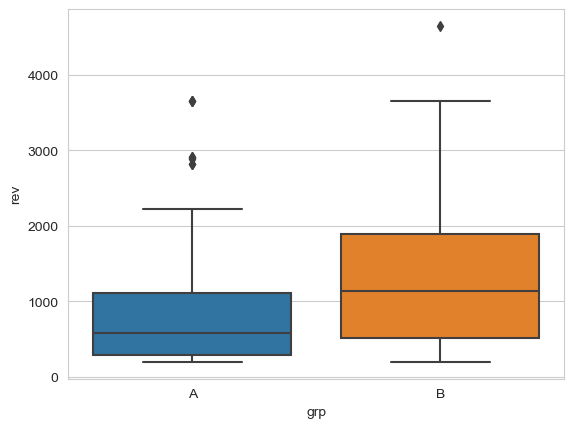

In [43]:
df_boxplot = fin_df.query('rev != 0')
sns.boxplot(data = df_boxplot, x = 'grp', y = 'rev')
# 

 Медианные значения также очень сильно отличаются. Посмотрим на распределени.

In [44]:
df_1 = fin_df.query('grp == "A" & rev != 0')

In [45]:
df_2 = fin_df.query('grp == "B" & rev != 0')

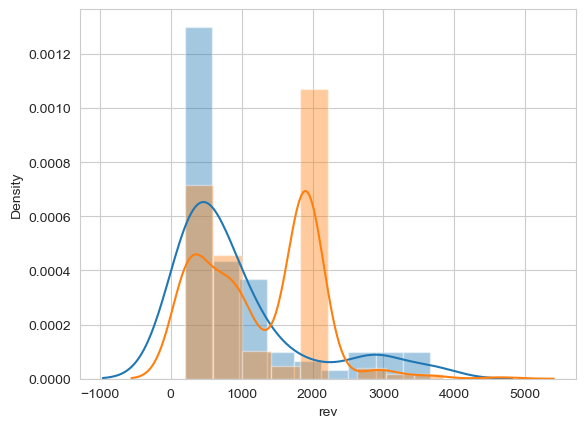

In [46]:
with warnings.catch_warnings(record=True):
    sns.distplot(df_1.rev)
    sns.distplot(df_2.rev)

Распределение не кажется нормальным. Проведем тест на нормальность.

In [47]:
pg.normality(data=fin_df, dv="rev", group="grp", method="normaltest")

,W,pval,normal
grp,,,
A,2240.595797,0.0,False
B,7797.399212,0.0,False


Выборки достаточно большие (болше 30 наблюдений) и несмотря на проваленный тест можно применить t-тест.
H₀: Между средними нет статистически значимых различий.(Нулевая гипотеза)
H₁: Статистически значимые различия есть.(Альтернативная гипотеза)

In [48]:
stats.ttest_ind(df_1.rev, df_2.rev)

TtestResult(statistic=-3.1337795050930985, pvalue=0.0018562025265765867, df=390.0)

pValue меньше 0.05, значит мы имееем право отклонить нулевую гипотезу и принять альтернативную:   
**Мы имеем статистически-значимую разницу между двумя выборками**.

В исследовании результатов A/B-тестирования мы сравнивали 2 метрики продукта: конверсию в покупку и средний чек.  
**Конверсия в покупку**: результаты целевой группы оказались хуже, чем результаты контрольной примерно на 0,45%(4,62% и 5,07%.
Проведенный тест хи-квадрат не выявил статистически значимых различий между группами.  
**Средний чек**: Средний чек у целевой группы оказался выше на 324 единицы, чем у контрольной. T-тест на равенство средних показал статистически значимые различии.


 ### Вывод<h3>  

Основываясь на полученных данных, можно сделать вывод, что целевой способ оплаты увеличивает средний чек. А при схожей конверсии в покупку увеличит и общую выручку.   
Этот вывод можно сделать только теоретически. К сожалению, практически мне мешает отсутствие некоторых второстепенных условий:
  1. Мне не понятен принцип распределения пользователей на группы. Изначально они распределены так, что выборки получаться разными по размеру.
  2. Для значимости эксперимента лучше делить пользователей в момент, когда они посещают сайт, а не до него. Так выборки оказались бы примерно равными по размеру.
  3. К сожалению, в этом тесте я не имею информацию о том, насколько сильно и как поменялась механика оплаты. Ведь изменения в первую очередь должны повлиять на конверсию, а не на средний чек (конечно, если изменения повлияли на более "дорогие" или более "объёмные" покупки, то тут понятны расхождения в данных). Такое расхождение средних чеков могло бы быть, если пользователи распределены по группам не случайно, а по какому-нибудь признаку (например,город-область).  
  
**В итоге:** Новую механику оплаты однозначно **выпускать** на всех пользователей. 

## Задание 2. SQL<h2>
**2.1 Очень усердные ученики.**  
**Условие**

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".
Необходимо написать *оптимальный* запрос, который даст информацию о количестве очень усердных студентов

In [49]:
import pandahouse as ph
import pandas as pd
import getpass

In [51]:
#объявляем параметры подключения
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':getpass.getpass('Введите свой пароль: ')
                     }

Введите свой пароль:  ········


In [52]:
#пишем запрос, и получаем данные из clickhouse в pandas dataframe
query = """
SELECT COUNT(st_id) AS count_diligent_students
FROM(
    SELECT st_id, COUNT(DISTINCT(toMonth(timest))), COUNT(correct) AS result
    FROM default.peas
    WHERE correct = TRUE
    GROUP BY st_id
    HAVING result >= 20
    ) AS Q1
"""
df = ph.read_clickhouse(query, connection=connection_default)
df

,count_diligent_students
0,136


Это оптимальный запрос для подсчёта усердных студентов. В этом запросе учитывается, что в таблице данные только за 2 два дня одного месяца. В этом случае работу со временем можно не вести.

In [53]:
#пишем запрос, в котором учитывается сегодняшняя дата.
query = """
SELECT COUNT(st_id) AS count_diligent_students
FROM(
    SELECT st_id, COUNT(DISTINCT(toMonth(timest))), COUNT(correct) AS result
    FROM default.peas
    WHERE (correct = 1) AND (toMonth(timest) = toMonth(NOW())) AND (toYear(timest) = toYear(NOW()))
    GROUP BY st_id
    HAVING result >= 20
    ) AS Q1
"""
df = ph.read_clickhouse(query, connection=connection_default)
df

,count_diligent_students
0,0


Это оптимальный запрос для подсчёта усердных студентов, если бы в БД была бы текущая информация (учитывается месяц и год). Выполняется некорректно, т.к. данные в этой БД неполные.

**2.2. Оптимизация воронки.**  
**Условие.**

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
- ARPU считается относительно всех пользователей, попавших в группы.

In [54]:
query = """
WITH  (
SELECT COUNT(DISTINCT if(money > 0, st_id, NULL)) AS active_st
FROM 
(SELECT st_id, SUM(correct), money
FROM
(SELECT st_id, toDate(timest), correct, a.subject, test_grp, toDate(sale_time), money, b.subject 
FROM (SELECT st_id, timest, correct, subject, test_grp
    FROM peas
FULL JOIN studs
USING st_id) AS a
FULL JOIN final_project_check AS b
ON a.st_id = b.st_id
)
GROUP BY st_id, money
HAVING SUM(correct) > 10)) AS active_st,

(SELECT COUNT(if(buy_subject = 'Math', st_id, NULL)) / COUNT(if(sum_correct > 2, st_id, NULL)) AS cr_buy_math
FROM
(SELECT st_id, SUM(correct) AS sum_correct, subject, buy_subject
FROM
(SELECT st_id, toDate(timest), correct, a.subject AS subject, test_grp, toDate(sale_time), money, b.subject AS buy_subject
FROM (SELECT st_id, timest, correct, subject, test_grp
    FROM peas
FULL JOIN studs
USING st_id) AS a
FULL JOIN final_project_check AS b
ON a.st_id = b.st_id)
WHERE subject == 'Math'
GROUP BY st_id, subject, buy_subject)) AS cr_buy_math

SELECT 
    (SUM(money) / COUNT(DISTINCT st_id)) * (COUNT(DISTINCT if(money > 0, st_id, NULL)) / COUNT(DISTINCT st_id)) AS ARPU,
    (SUM(money) / COUNT(DISTINCT st_id)) * active_st / COUNT(DISTINCT st_id) AS ARPAU,
    COUNT(DISTINCT if(money > 0, st_id, NULL)) / COUNT(DISTINCT st_id) AS cr_buy,
    active_st / COUNT(DISTINCT st_id) AS cr_active,
    cr_buy_math
FROM
(SELECT st_id, toDate(timest), correct, a.subject, test_grp, toDate(sale_time), money, b.subject 
FROM (SELECT st_id, timest, correct, subject, test_grp
    FROM peas
FULL JOIN studs
USING st_id) AS a
FULL JOIN final_project_check AS b
ON a.st_id = b.st_id
) AS st

"""
df_1 = ph.read_clickhouse(query, connection=connection_default)
df_1.rename(columns = {'cr_buy': 'CR в покупку','cr_active':'СR активного пользователя в покупку',
                       'cr_buy_math':'CR пользователя из активности по математике в покупку курса по математике' }, inplace = True)

In [55]:
df_1

,ARPU,ARPAU,CR в покупку,СR активного пользователя в покупку,CR пользователя из активности по математике в покупку курса по математике
0,28064.222222,23287.333333,0.078333,0.065,0.072917


## Задание 3. Python<h2>
**3.1 Задача**

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
      
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [56]:
def function_group_add(url):
    key = url  
    delimiter = ','
    groups_add = read_df_API(key, delimiter)
    
    group_fin = pd.concat([group, groups_add]) #Объединяем 2 датафрейма
    value_counts = group_fin.grp.value_counts()
    print(f'Количество учеников по группам')
    print(value_counts)
    sns.countplot(x='grp', data = group_fin)
    plt.title('Количество учеников по группам')
    plt.show()
    # Проверка уникальности значений столбца
    def uniqualy(df1):
        if len(df1) == df1.nunique():
            print('Все значения уникальны')
        else:
            print('Не все значения уникальны')
    uniqualy(group_fin.id)
    print('\n')
    active_studs_group = active_studs.merge(group_fin, left_on='student_id', right_on='id', how = 'left')
    active_studs_group = active_studs_group.drop(['id'], axis = 1)
    sum_nan = active_studs_group.isna().sum()
    if sum_nan[0] != 0 or sum_nan[1] != 0:
        active_studs_group = active_studs_group.dropna()
        print('Удаление записей с Nan')
        print('\n')
    fin_df = active_studs_group.merge(checks, on = 'student_id', how = 'outer')
    fin_df # Получаем финальный датафрейм, Nan меняем на нули: пользователь был, но не оплатил
    fin_df.fillna(0, inplace = True)
    bug_id = fin_df.query('grp == 0').rename(columns={'student_id' : 'id', 'grp' : 'group'})
    bug_id = bug_id.merge(group_fin, on = 'id', how = 'left')
    not_in_test = bug_id.grp.isna().sum()
    bug = bug_id.grp.notna().sum()
    print(f'Ошибки - {bug}, пользователей нераспределённых - {not_in_test}')
    print('\n')    
    fin_df = fin_df.query('grp != 0')
    uniqualy(fin_df.student_id)
    print('\n')
    agg_fin_df_cr = fin_df.query('rev != 0').groupby('grp', as_index = False).agg({'student_id':'count'})\
        .rename(columns={'student_id':'paid'})
    agg_fin_df_cr_all_students =  fin_df.groupby('grp', as_index = False).agg({'student_id':'count'})\
        .rename(columns={'student_id':'all'})
    agg_fin_df_cr = agg_fin_df_cr.merge(agg_fin_df_cr_all_students, on = 'grp')
    agg_fin_df_cr['cr'] = agg_fin_df_cr['paid'] / agg_fin_df_cr['all']*100
    print('Метрика cr\n', agg_fin_df_cr[['grp','cr']])
    print('\n')
    stat, p, dof, expected = stats.chi2_contingency(agg_fin_df_cr[['paid', 'all']])
    print(f'Коэффициент описательной статистики теста Хи-квадрат - {stat}, значение p-value - {p}') 
    print('\n')
    agg_fin_df = fin_df.query('rev != 0').groupby('grp', as_index = False).agg({'student_id':'count', 'rev':'sum'})
    agg_fin_df['avg_check'] = agg_fin_df.rev / agg_fin_df.student_id
    print('Метрика "средний чек"\n\n', agg_fin_df_cr[['grp','cr']])
    df_1 = fin_df.query('grp == "A" & rev != 0')
    df_2 = fin_df.query('grp == "B" & rev != 0')
    df_boxplot = fin_df.query('rev != 0')
    sns.boxplot(data = df_boxplot, x = 'grp', y = 'rev')
    plt.title('Распределение "rev" по группам')
    plt.show()
    sns.displot(df_boxplot, x = 'rev', hue = 'grp')
    plt.title('Распределение "rev"')
    plt.show()
    stat, p = stats.ttest_ind(df_1.rev, df_2.rev)
    print(f'Значение описательной статистики t-test - {stat}, значение pValue - {p}')

Количество учеников по группам
grp
B    59883
A    14693
Name: count, dtype: int64


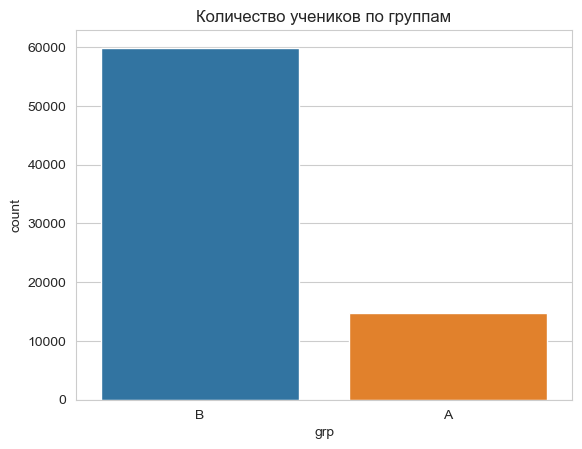

Все значения уникальны


Ошибки - 149, пользователей нераспределённых - 0


Все значения уникальны


Метрика cr
   grp        cr
0   A  5.071521
1   B  4.615611


Коэффициент описательной статистики теста Хи-квадрат - 0.43612258061018483, значение p-value - 0.5089998823014525


Метрика "средний чек"

   grp        cr
0   A  5.071521
1   B  4.615611


C:\Users\OlegK\AppData\Local\Temp\ipykernel_20960\3636781897.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if sum_nan[0] != 0 or sum_nan[1] != 0:


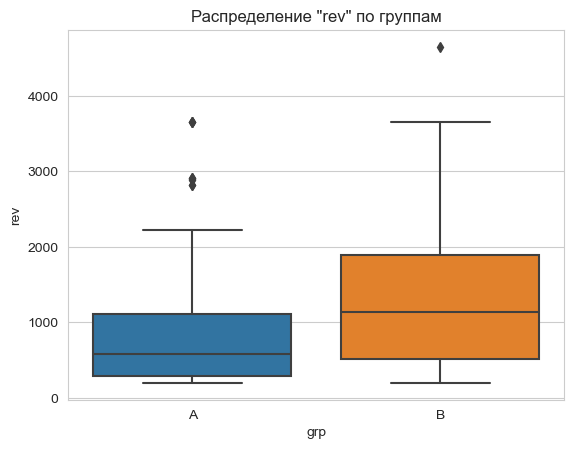

C:\Users\OlegK\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


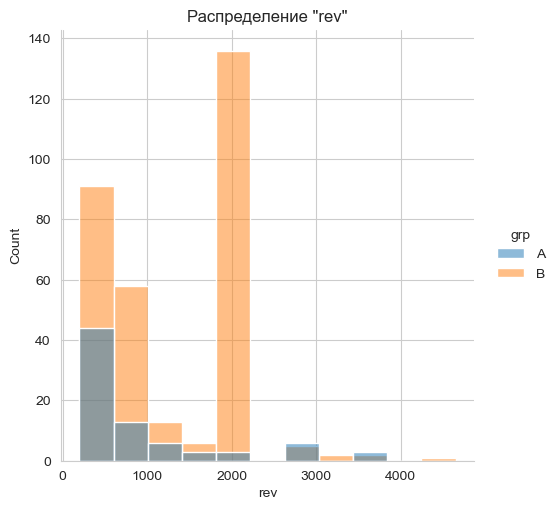

Значение описательной статистики t-test - -3.1337795050930985, значение pValue - 0.0018562025265765867


In [57]:
function_group_add('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ')